In [138]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
import random

# FindingMino Miniproject

- **Task**: take as input two MNIST images and through a neural network return the value of the minimum digit

- **Restrictions**: no intermediate labels can be used, ie a classifier that reveals what digits the images represent cannot be followed by logic to choose the minimum value

- **Approach**: as a variation of Gonzalo's proposed method, place images side-by-side and then make the label of that combined image be the minimum value

- **Implementation**: convolutional neural network with three convolutional layers interspersed by two max pooling layers, followed by a deep neural network with one hidden layer and a dropout layer prior to the output layer. 

In [139]:
# Load data and split into training and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

(28, 28)


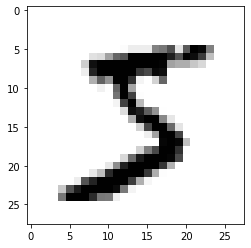

In [140]:
image_A = train_images[0]
print(image_A.shape)
plt.imshow(image_A, cmap = plt.cm.binary)

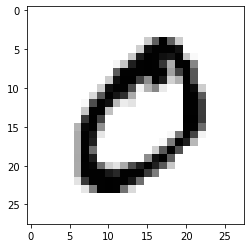

In [141]:
image_B = train_images[1]
plt.imshow(image_B, cmap = plt.cm.binary)

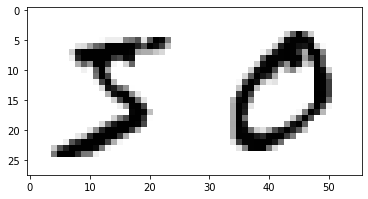

In [142]:
images_A_and_B = np.hstack((image_A, image_B))
plt.imshow(images_A_and_B, cmap = plt.cm.binary)

In [143]:
# Split training set further into training and validation sets
sample_size = 40000
X_train, X_val, y_train, y_val = train_images[:sample_size], train_images[sample_size:sample_size*2],  train_labels[:sample_size], train_labels[sample_size:sample_size*2]

Randomly sampling a subset of the data, to make the combinations more tractable. 

In [145]:
# Randomly select a defined number of image paires from a given dataset
def get_image_combinations(number_image_pairs_selected, image_data, image_labels):
    
    num_images_total = len(image_labels)
    
    image_combination_data = []
    image_combination_labels = []
    
    for i in range(number_image_pairs_selected):
        
        # Draw two image indices from a uniform random distribution
        random_index_A = random.randint(0, num_images_total-1)
        random_index_B = random.randint(0, num_images_total-1)
        
        # Randomly choose two images from the dataset
        image_A = image_data[random_index_A]
        image_B = image_data[random_index_B]
        
        # Merge images
        combined_images = np.hstack((image_A, image_B))
        
        # Find the minimum between the two labels
        label_A = image_labels[random_index_A]
        label_B = image_labels[random_index_B]
        minimum_label = min(label_A, label_B)
        
        # Append newly generated image combination and minimum label to list
        image_combination_data.append(combined_images)
        image_combination_labels.append(minimum_label)
        
    # Convert image data and labels lists to numpy arrays
    image_combination_data = np.array(image_combination_data)
    image_combination_labels = np.array(image_combination_labels)
    
    return image_combination_data, image_combination_labels

In [147]:
combo_train_X, combo_train_y = get_image_combinations(40000, X_train, y_train)
combo_val_X, combo_val_y = get_image_combinations(20000, X_val, y_val)

In [148]:
combo_train_X.shape

(40000, 28, 56)

In [149]:
combo_train_y.shape

(40000,)

In [150]:
# Reshape the data so they can be fed into the network, one-hot-encode the labels

train_images = combo_train_X.reshape((combo_train_X.shape[0], 28, 56, 1))
train_images = train_images/ 255

val_images = combo_val_X.reshape((combo_val_X.shape[0], 28, 56, 1))
val_images = val_images/255

train_labels = to_categorical(combo_train_y)
val_labels = to_categorical(combo_val_y)

In [151]:
train_labels.shape

(40000, 10)

In [152]:
train_images.shape

(40000, 28, 56, 1)

In [153]:
# Model architecture
def build_CNN():

    # Convolutional NN
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,56,1)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    # Adding a NN Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(10, activation = 'softmax'))

    model.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy', 'mae'])

    return model

In [154]:
model = build_CNN()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 54, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 27, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 12, 64)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 10, 64)         36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)              

In [155]:
# Fit model
model.fit(train_images, 
          train_labels, 
          epochs = 8, 
          batch_size = 64)


Epoch 1/8
625/625 [==============================] - 28s 44ms/step - loss: 0.4635 - accuracy: 0.8491 - mae: 0.0442
Epoch 2/8
625/625 [==============================] - 29s 47ms/step - loss: 0.1321 - accuracy: 0.9575 - mae: 0.0132
Epoch 3/8
625/625 [==============================] - 42s 67ms/step - loss: 0.0744 - accuracy: 0.9763 - mae: 0.0074
Epoch 4/8
625/625 [==============================] - 34s 54ms/step - loss: 0.0463 - accuracy: 0.9850 - mae: 0.0047
Epoch 5/8
625/625 [==============================] - 32s 52ms/step - loss: 0.0312 - accuracy: 0.9901 - mae: 0.0031
Epoch 6/8
625/625 [==============================] - 32s 51ms/step - loss: 0.0207 - accuracy: 0.9931 - mae: 0.0021
Epoch 7/8
625/625 [==============================] - 32s 52ms/step - loss: 0.0168 - accuracy: 0.9944 - mae: 0.0017
Epoch 8/8
625/625 [==============================] - 33s 52ms/step - loss: 0.0118 - accuracy: 0.9961 - mae: 0.0012


In [129]:
# Create a set of predictions
y_predict = model.predict(val_images)

In [118]:
# Compare predictions to validation labels and return the proportion correctly classified
correct = 0

for label in range(len(val_labels)):
    
    if np.argmax(val_labels[label], axis=None, out=None) == np.argmax(y_predict[label], axis=None, out=None):
        correct = correct + 1
        
print("Val Accuracy: " + str(correct/len(val_labels)))

Val Accuracy: 0.7639


In [119]:
# Print loss, mae and accuracy
eval_model = model.evaluate(val_images, val_labels)
eval_model

313/313 [==============================] - 1s 4ms/step - loss: 0.7332 - accuracy: 0.7639 - mae: 0.0578


[0.7332252860069275, 0.7638999819755554, 0.05778397247195244]

In [31]:
# Set up parameters for k-fold cross-validation
k = 5
num_val_samples = len(train_images)//k

num_epochs = 2000
all_mae_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    val_mae_history = history.history['val_mae']
    all_mae_histories.append(val_mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


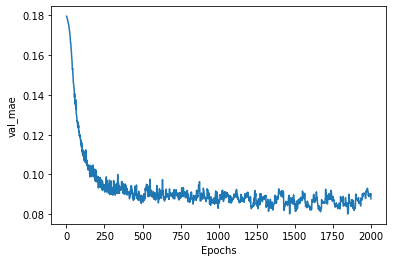

In [32]:
# Compute the average of the per-epoch MAE scores for all folds
# Building the history of successive mean K-fold validation scores

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()

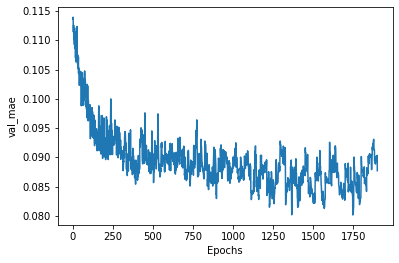

In [33]:
plt.plot(range(1, len(average_mae_history[100:]) + 1), average_mae_history[100:])
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()

In [34]:
def smooth_curve(points, factor=0.5):
    
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 -factor))
        else:
            smoothed_points.append(point)
            
    return smoothed_points

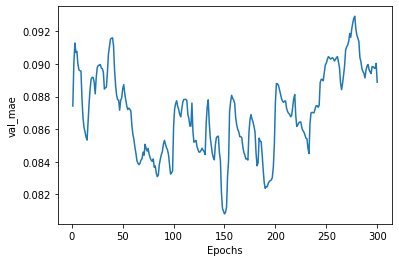

In [38]:
smooth_mae_history = smooth_curve(average_mae_history)
plt.plot(range(1, len(smooth_mae_history[1700:]) + 1), smooth_mae_history[1700:])
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()

In [36]:
# serialize model to JSON
model_json = model.to_json()
with open("Trained_Models/Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Trained_Models/Model.h5")
print("Saved model to disk")

Saved model to disk


In [9]:
# Verify above by visually inspecting images from the predicted set
num_val_images = 10000

Predicted: 5
True: 7


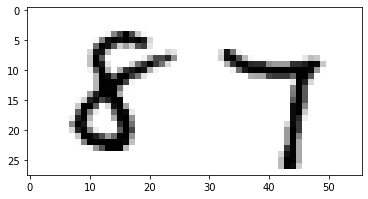

In [21]:
# Run this cell repeatedly to see multiple examples
check_index = random.randint(0,num_val_images)
plt.imshow(val_images[check_index].reshape(28,56), cmap = plt.cm.binary)
print("Predicted: " + str(np.argmax(y_predict[check_index])))
print("True: " + str(np.argmax(val_labels[check_index])))

In [159]:
# Model architecture
def build_DNN():

    # Convolutional NN
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, activation = 'relu', input_shape=(28*56,)))
    model.add(layers.Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy', 'mae'])

    return model

In [163]:
train_images.shape

(40000, 28, 56, 1)

In [170]:
train_images = train_images.reshape(40000, 28*56,)
val_images = val_images.reshape(20000, 28*56,)

In [171]:
dnn = build_DNN()
dnn.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               803328    
_________________________________________________________________
dense_30 (Dense)             (None, 10)                5130      
Total params: 808,458
Trainable params: 808,458
Non-trainable params: 0
_________________________________________________________________


In [172]:
# Fit model
dnn.fit(train_images, 
          train_labels, 
          epochs = 8, 
          batch_size = 64)

Epoch 1/8
625/625 [==============================] - 2s 3ms/step - loss: 0.6123 - accuracy: 0.7994 - mae: 0.0588: 0s - loss: 0.7
Epoch 2/8
625/625 [==============================] - 2s 3ms/step - loss: 0.3004 - accuracy: 0.9061 - mae: 0.0301
Epoch 3/8
625/625 [==============================] - 2s 3ms/step - loss: 0.2041 - accuracy: 0.9366 - mae: 0.0206
Epoch 4/8
625/625 [==============================] - 2s 3ms/step - loss: 0.1429 - accuracy: 0.9552 - mae: 0.0149
Epoch 5/8
625/625 [==============================] - 2s 3ms/step - loss: 0.0981 - accuracy: 0.9695 - mae: 0.0108
Epoch 6/8
625/625 [==============================] - 2s 3ms/step - loss: 0.0692 - accuracy: 0.9793 - mae: 0.0077
Epoch 7/8
625/625 [==============================] - 2s 3ms/step - loss: 0.0476 - accuracy: 0.9851 - mae: 0.0057
Epoch 8/8
625/625 [==============================] - 2s 3ms/step - loss: 0.0323 - accuracy: 0.9904 - mae: 0.0040


In [173]:
# Print loss, mae and accuracy
eval_model = dnn.evaluate(val_images, val_labels)
eval_model

625/625 [==============================] - 1s 966us/step - loss: 0.3235 - accuracy: 0.9262 - mae: 0.0170


[0.32349351048469543, 0.9262499809265137, 0.016996102407574654]

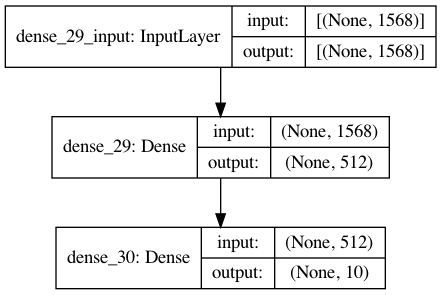

In [175]:
keras.utils.plot_model(dnn, "dnn.png", show_shapes=True)